In [1]:
import torch 
from matplotlib import pyplot as plt 
from einops import rearrange
import seaborn as sns 
import os 
import numpy as np
import io

<Figure size 2000x500 with 0 Axes>

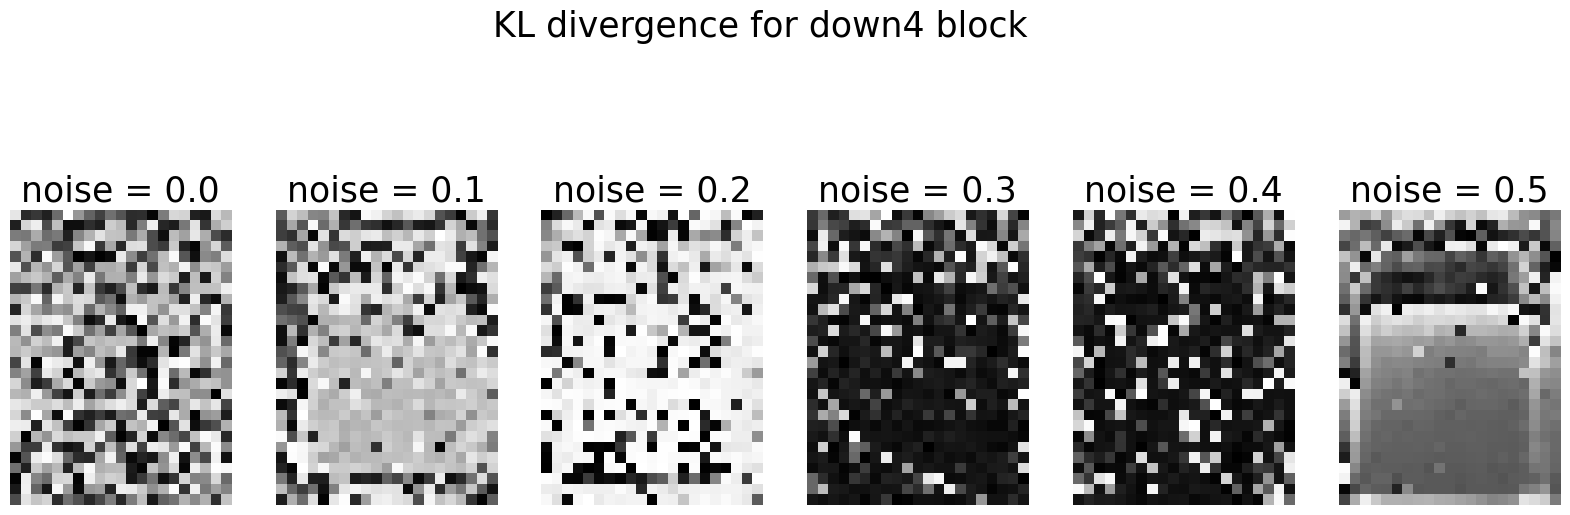

In [4]:
kl_divs = ['down4raw.png']#, 'up1raw.png']
kl_divs = ['down4std.png']#, 'up1norm.png']
plt.figure(figsize=(20, 5))
for kl_div in kl_divs:
    plt.figure(figsize=(20, 5))
    plt.suptitle('KL divergence for {} block'.format(kl_div[:-7]), fontsize=25, y=1.4)
    plt.subplots_adjust(top=1.3)
    plt.tight_layout()
    for i, noise_dir in enumerate(sorted(os.listdir('visualization'))): 
        plt.subplot(1, 6, i+1) 
        plt.title('noise = ' +noise_dir, fontsize=25)
        plt.imshow(plt.imread(os.path.join('visualization', noise_dir, kl_div)), cmap='gray')
        plt.axis('off')
              
    plt.savefig('kl_div_{}.png'.format(kl_div[:-7]), bbox_inches='tight', dpi=300)
    plt.show()

/home/shivac/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


down4/unet_mean.pt: torch.Size([28, 21, 512]), down4/q_unet_mean.pt: torch.Size([28, 21, 512])
down4/unet_mean.pt: torch.Size([28, 21, 512]), down4/q_unet_mean.pt: torch.Size([28, 21, 512])
down4/unet_mean.pt: torch.Size([28, 21, 512]), down4/q_unet_mean.pt: torch.Size([28, 21, 512])
down4/unet_mean.pt: torch.Size([28, 21, 512]), down4/q_unet_mean.pt: torch.Size([28, 21, 512])
down4/unet_mean.pt: torch.Size([28, 21, 512]), down4/q_unet_mean.pt: torch.Size([28, 21, 512])
down4/unet_mean.pt: torch.Size([28, 21, 512]), down4/q_unet_mean.pt: torch.Size([28, 21, 512])


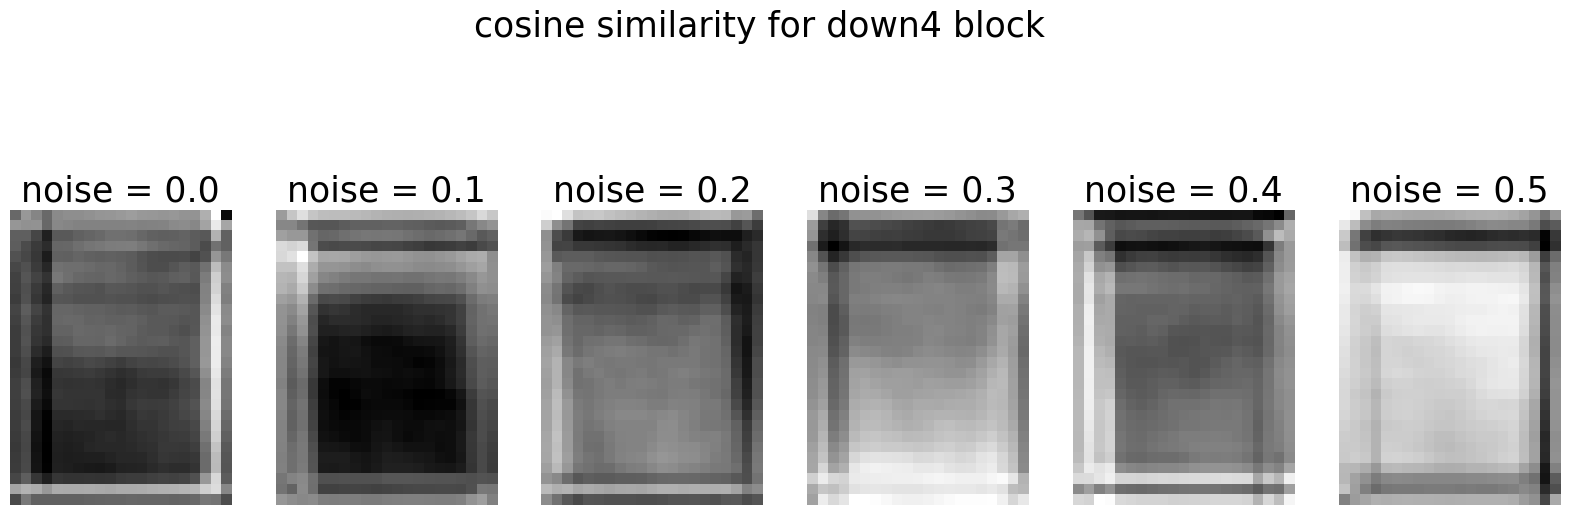

In [5]:
kl_divs = ['down4/unet_mean.pt', 'down4/q_unet_mean.pt']
plt.figure(figsize=(20, 5))
plt.suptitle('KL divergence', fontsize=25, y=1.5)
plt.subplots_adjust(top=1.3)
for i, noise_dir in enumerate(sorted(os.listdir('visualization'))): 
    plt.subplot(1, 6, i+1) 
    plt.suptitle('cosine similarity for down4 block'.format(kl_div[:-7]), fontsize=25, y=1.4)
    plt.subplots_adjust(top=1.3)
    plt.title('noise = ' + noise_dir, fontsize=25)
    unet_mean = torch.load(os.path.join('visualization', noise_dir, kl_divs[0])).cuda()
    q_unet_mean = torch.load(os.path.join('visualization', noise_dir, kl_divs[1])).cuda()
    print(f'{kl_divs[0]}: {unet_mean.shape}, {kl_divs[1]}: {q_unet_mean.shape}')
    unet_mean = unet_mean/torch.norm(unet_mean, dim=-1, keepdim=True)
    q_unet_mean = q_unet_mean/torch.norm(q_unet_mean, dim=-1, keepdim=True)
    cos_sim = unet_mean * q_unet_mean 
    cos_sim = torch.sum(cos_sim, dim=-1)
    plt.imshow(cos_sim.cpu(), cmap='gray')
    plt.axis('off')
plt.savefig('cosine_similarity_{}.png'.format(kl_divs[0].split('/')[0]), bbox_inches='tight', dpi=300)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'visualization/0.0/up1/unet_mean.pt'

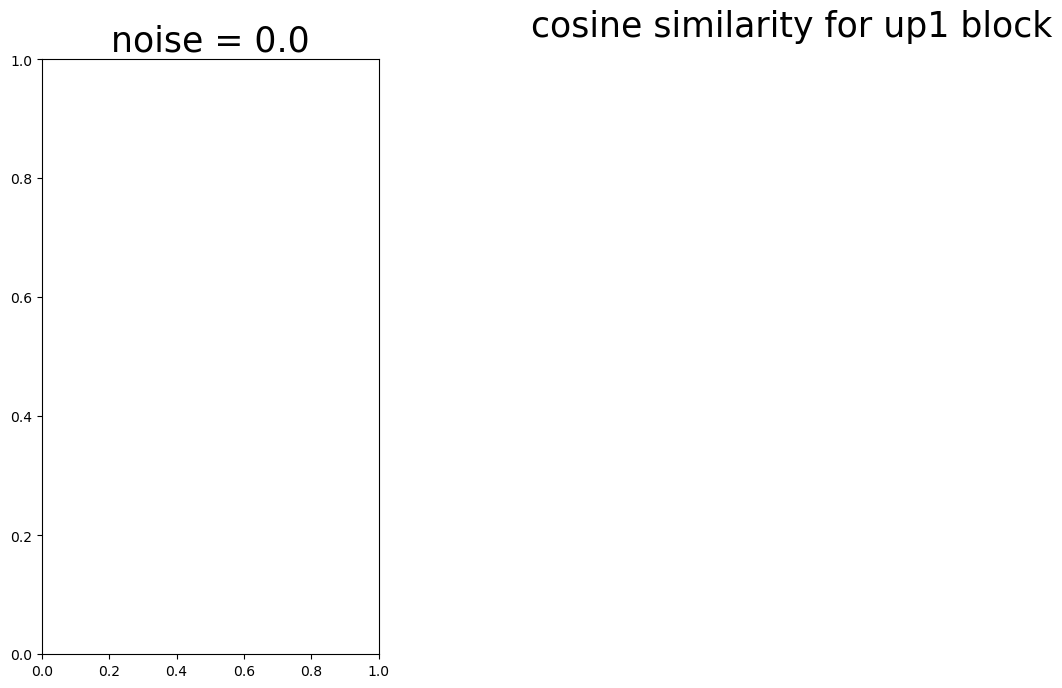

In [6]:
kl_divs = ['up1/unet_mean.pt', 'up1/q_unet_mean.pt']
plt.figure(figsize=(20, 5))
for i, noise_dir in enumerate(sorted(os.listdir('visualization'))): 
    plt.subplot(1, 4, i+1) 
    plt.suptitle('cosine similarity for up1 block'.format(kl_div[:-7]), fontsize=25, y=1.4)
    plt.subplots_adjust(top=1.3)
    plt.title('noise = ' + noise_dir, fontsize=25)
    unet_mean = torch.load(os.path.join('visualization', noise_dir, kl_divs[0])).cuda()
    q_unet_mean = torch.load(os.path.join('visualization', noise_dir, kl_divs[1])).cuda()
    unet_mean = unet_mean/torch.norm(unet_mean, dim=-1, keepdim=True)
    q_unet_mean = q_unet_mean/torch.norm(q_unet_mean, dim=-1, keepdim=True)
    cos_sim = unet_mean * q_unet_mean 
    cos_sim = torch.sum(cos_sim, dim=-1)
    plt.imshow(cos_sim.cpu(), cmap='gray')
    plt.axis('off')
plt.savefig('cosine_similarity_{}.png'.format(kl_divs[0].split('/')[0]), bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
from torch import nn 
from unet import UpBlock, DownBlock, DoubleConv, Q_Conv2d



class Q_UNET(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, n_qubits=28, bilinear=True):
        super().__init__() 
        self.n_qubits = n_qubits
        self.ch = DoubleConv(in_ch, 64)
        self.down1 = DownBlock(64, 128)
        self.down2 = DownBlock(128, 256)
        self.down3 = DownBlock(256, 512)
        self.qml_encoder = nn.Sequential(nn.Conv2d(512, 1, 1, 1), 
                                         Q_Conv2d(1, 1, 2, 2, num_layers=2),
                                         nn.Conv2d(1, 512, 1, 1))
                                       
        # self.qml_encoder = nn.Conv2d(512, 1, 1, 1)
        # self.qml_lay = Quanv(n_qubits, n_qubits)
        # self.qml_decoder = nn.Conv2d(1, 512, 1, 1)
        factor = 2 if bilinear else 1
        self.down4 = DownBlock(512, 1024//factor)

        self.up1 = UpBlock(1024, 512//factor, bilinear)
        self.up2 = UpBlock(512, 256//factor, bilinear)
        self.up3 = UpBlock(256, 128//factor, bilinear)
        self.up4 = UpBlock(128, 64, bilinear)
        self.out = nn.Sequential(nn.Conv2d(64, out_ch, kernel_size=1, stride=1),
                                 nn.Sigmoid())

    def forward(self, x, compute: str):
        if compute == 'ip': 
            return x 

        x0 = self.ch(x)
        if compute == 'ch': 
            return x0 

        x1 = self.down1(x0)
        if compute == 'down1': 
            return x1

        x2 = self.down2(x1)
        if compute == 'down2': 
            return x2

        x3 = self.down3(x2)
        if compute == 'down3': 
            return x3

        x = self.down4(x3)
        if compute == 'down4': 
            return x

        x = self.qml_encoder(x)
        print(f'{x.shape = }')
        if compute == 'qml_encoder': 
            return x

        x = self.up1(x, x3)
        if compute == 'up1': 
            return x

        x = self.up2(x, x2)
        if compute == 'up2': 
            return x

        x = self.up3(x, x1)
        if compute == 'up3': 
            return x

        x = self.up4(x, x0)
        if compute == 'up4': 
            return x

        out = self.out(x)
        if compute == 'out': 
            return x

        return out 



In [ ]:
from PIL import Image 
from torchvision import transforms as T
img = Image.open('../samples/im.png')
img = T.ToTensor()(img).unsqueeze(0)    
img.shape 

torch.Size([1, 3, 456, 342])

In [ ]:
model = Q_UNET(3, 1)
logits = model(img, compute='qml_encoder')

x.shape = torch.Size([1, 512, 14, 10])


In [ ]:
kl_div = torch.load('visualization/0.1/down4.pt') 
kl_div.shape

torch.Size([28, 21])

In [32]:
dirs = ['visualization/{}'.format(str(i)) for i in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]]
kl_plots = list()
kl_avgs = list()
for idx, dir in enumerate(dirs): 
    kl_div_path = os.path.join(dir, 'down4.pt') 
    kl_div = torch.load(kl_div_path).cpu().numpy() 
    kl_plots.append(kl_div)
    avg = np.mean(kl_div/1e12).round(5)
    kl_avgs.append(avg)


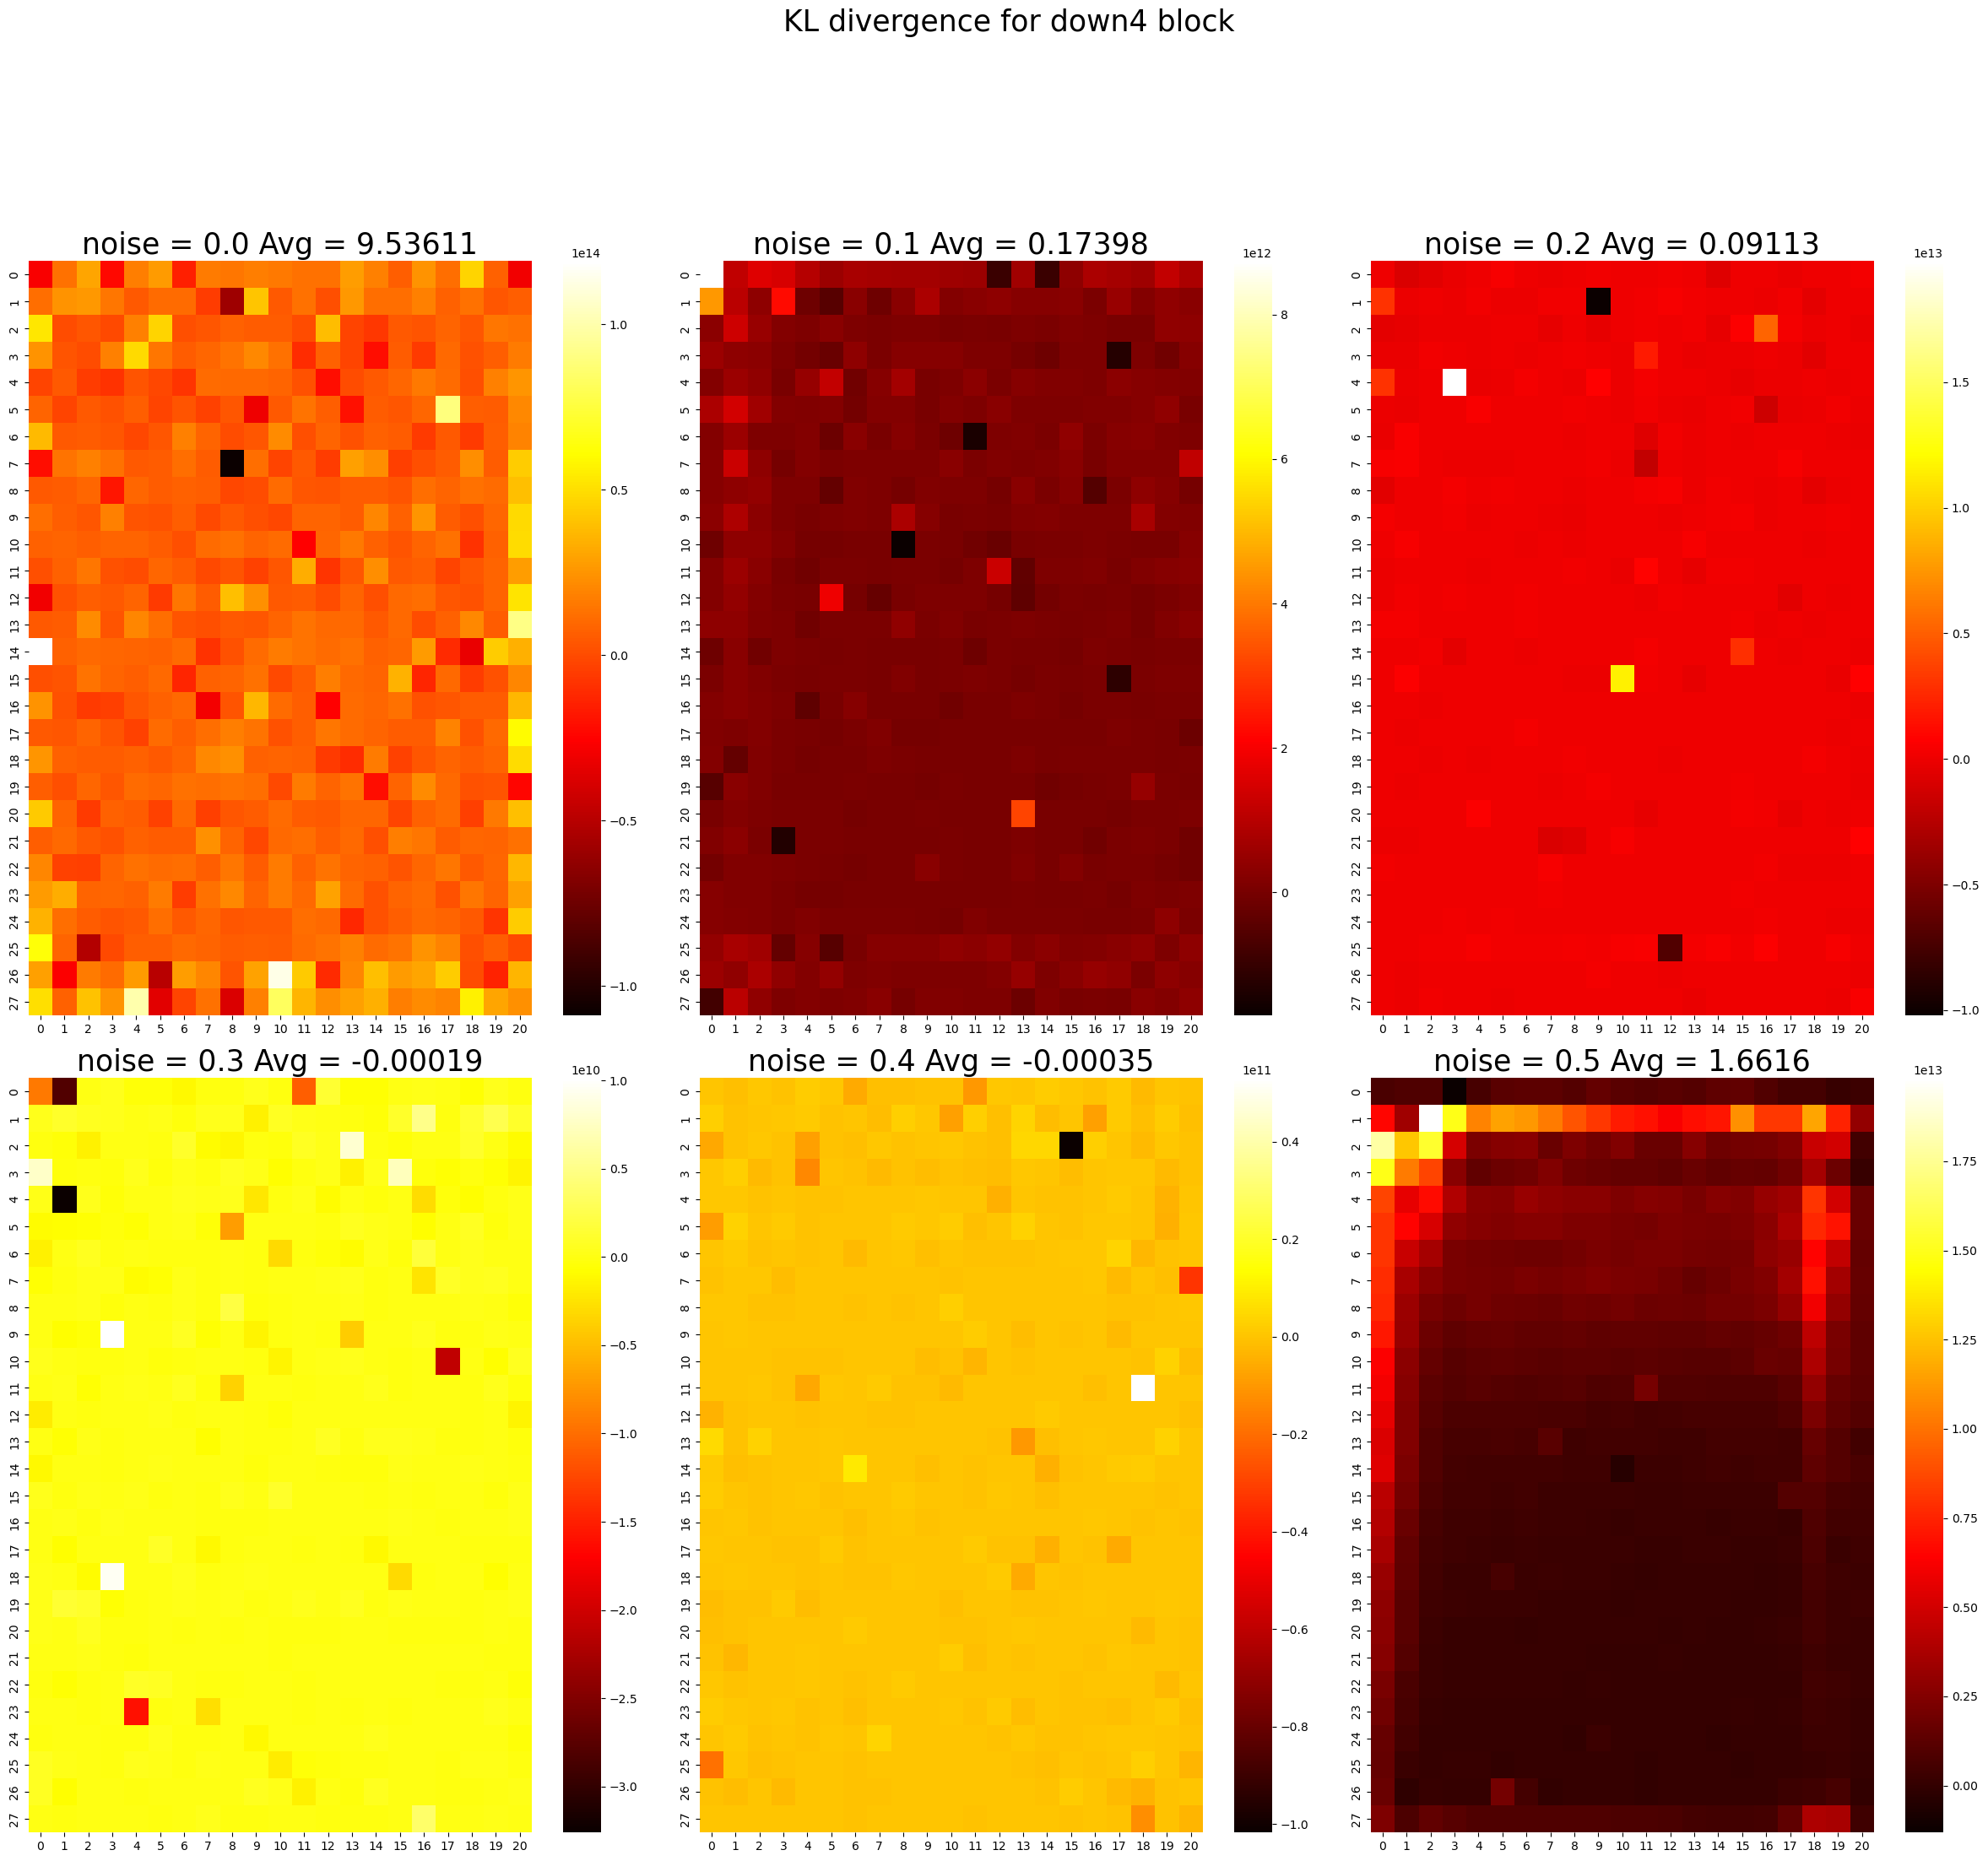

In [33]:
dirs = ['visualization/{}'.format(str(i)) for i in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]]
plt.figure(figsize=(24, 20))
plt.suptitle('KL divergence for down4 block', fontsize=25, y=1.1)
plt.subplots_adjust(top=1.2)
for idx, dir in enumerate(dirs): 
    plt.subplot(2, 3, idx+1)
    kl_div = kl_plots[idx]
    avg = kl_avgs[idx]
    plt.title('noise = {}'.format(dir.split('/')[-1]) + ' Avg = ' + str(avg), fontsize=25)
    sns.heatmap(kl_div, cmap='hot')
plt.tight_layout()
plt.show()


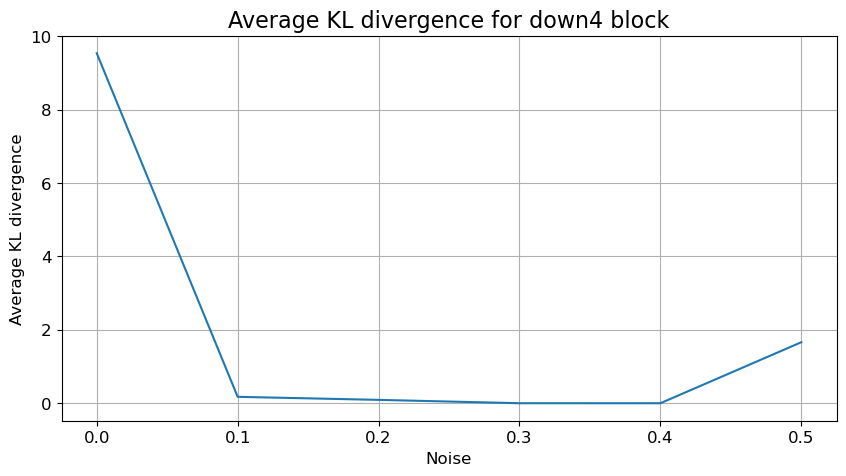

In [42]:
noise = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
plt.figure(figsize=(10, 5))
plt.plot(noise, kl_avgs)
plt.xlabel('Noise', fontsize=12)
plt.ylabel('Average KL divergence', fontsize=12)
plt.title('Average KL divergence for down4 block', fontsize=16)
plt.grid() 
plt.show()

In [13]:
def cos_sim(unet_mean, q_unet_mean): 
    unet_mean = unet_mean/torch.norm(unet_mean, dim=-1, keepdim=True)
    q_unet_mean = q_unet_mean/torch.norm(q_unet_mean, dim=-1, keepdim=True)
    cos_sim = unet_mean * q_unet_mean 
    cos_sim = torch.sum(cos_sim, dim=-1)
    return cos_sim

In [43]:
dirs = ['visualization/{}/down4'.format(str(i)) for i in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]]
cos_sims = list()
cos_avgs = list()
for idx, dir in enumerate(dirs): 
    unet_mean_path = os.path.join(dir, 'unet_mean.pt')
    q_unet_mean_path = os.path.join(dir, 'q_unet_mean.pt') 
    cos = cos_sim(torch.load(unet_mean_path), torch.load(q_unet_mean_path))
    cos_sims.append(cos)
    avg = torch.mean(cos).item()
    avg = round(avg, 5)
    cos_avgs.append(avg)



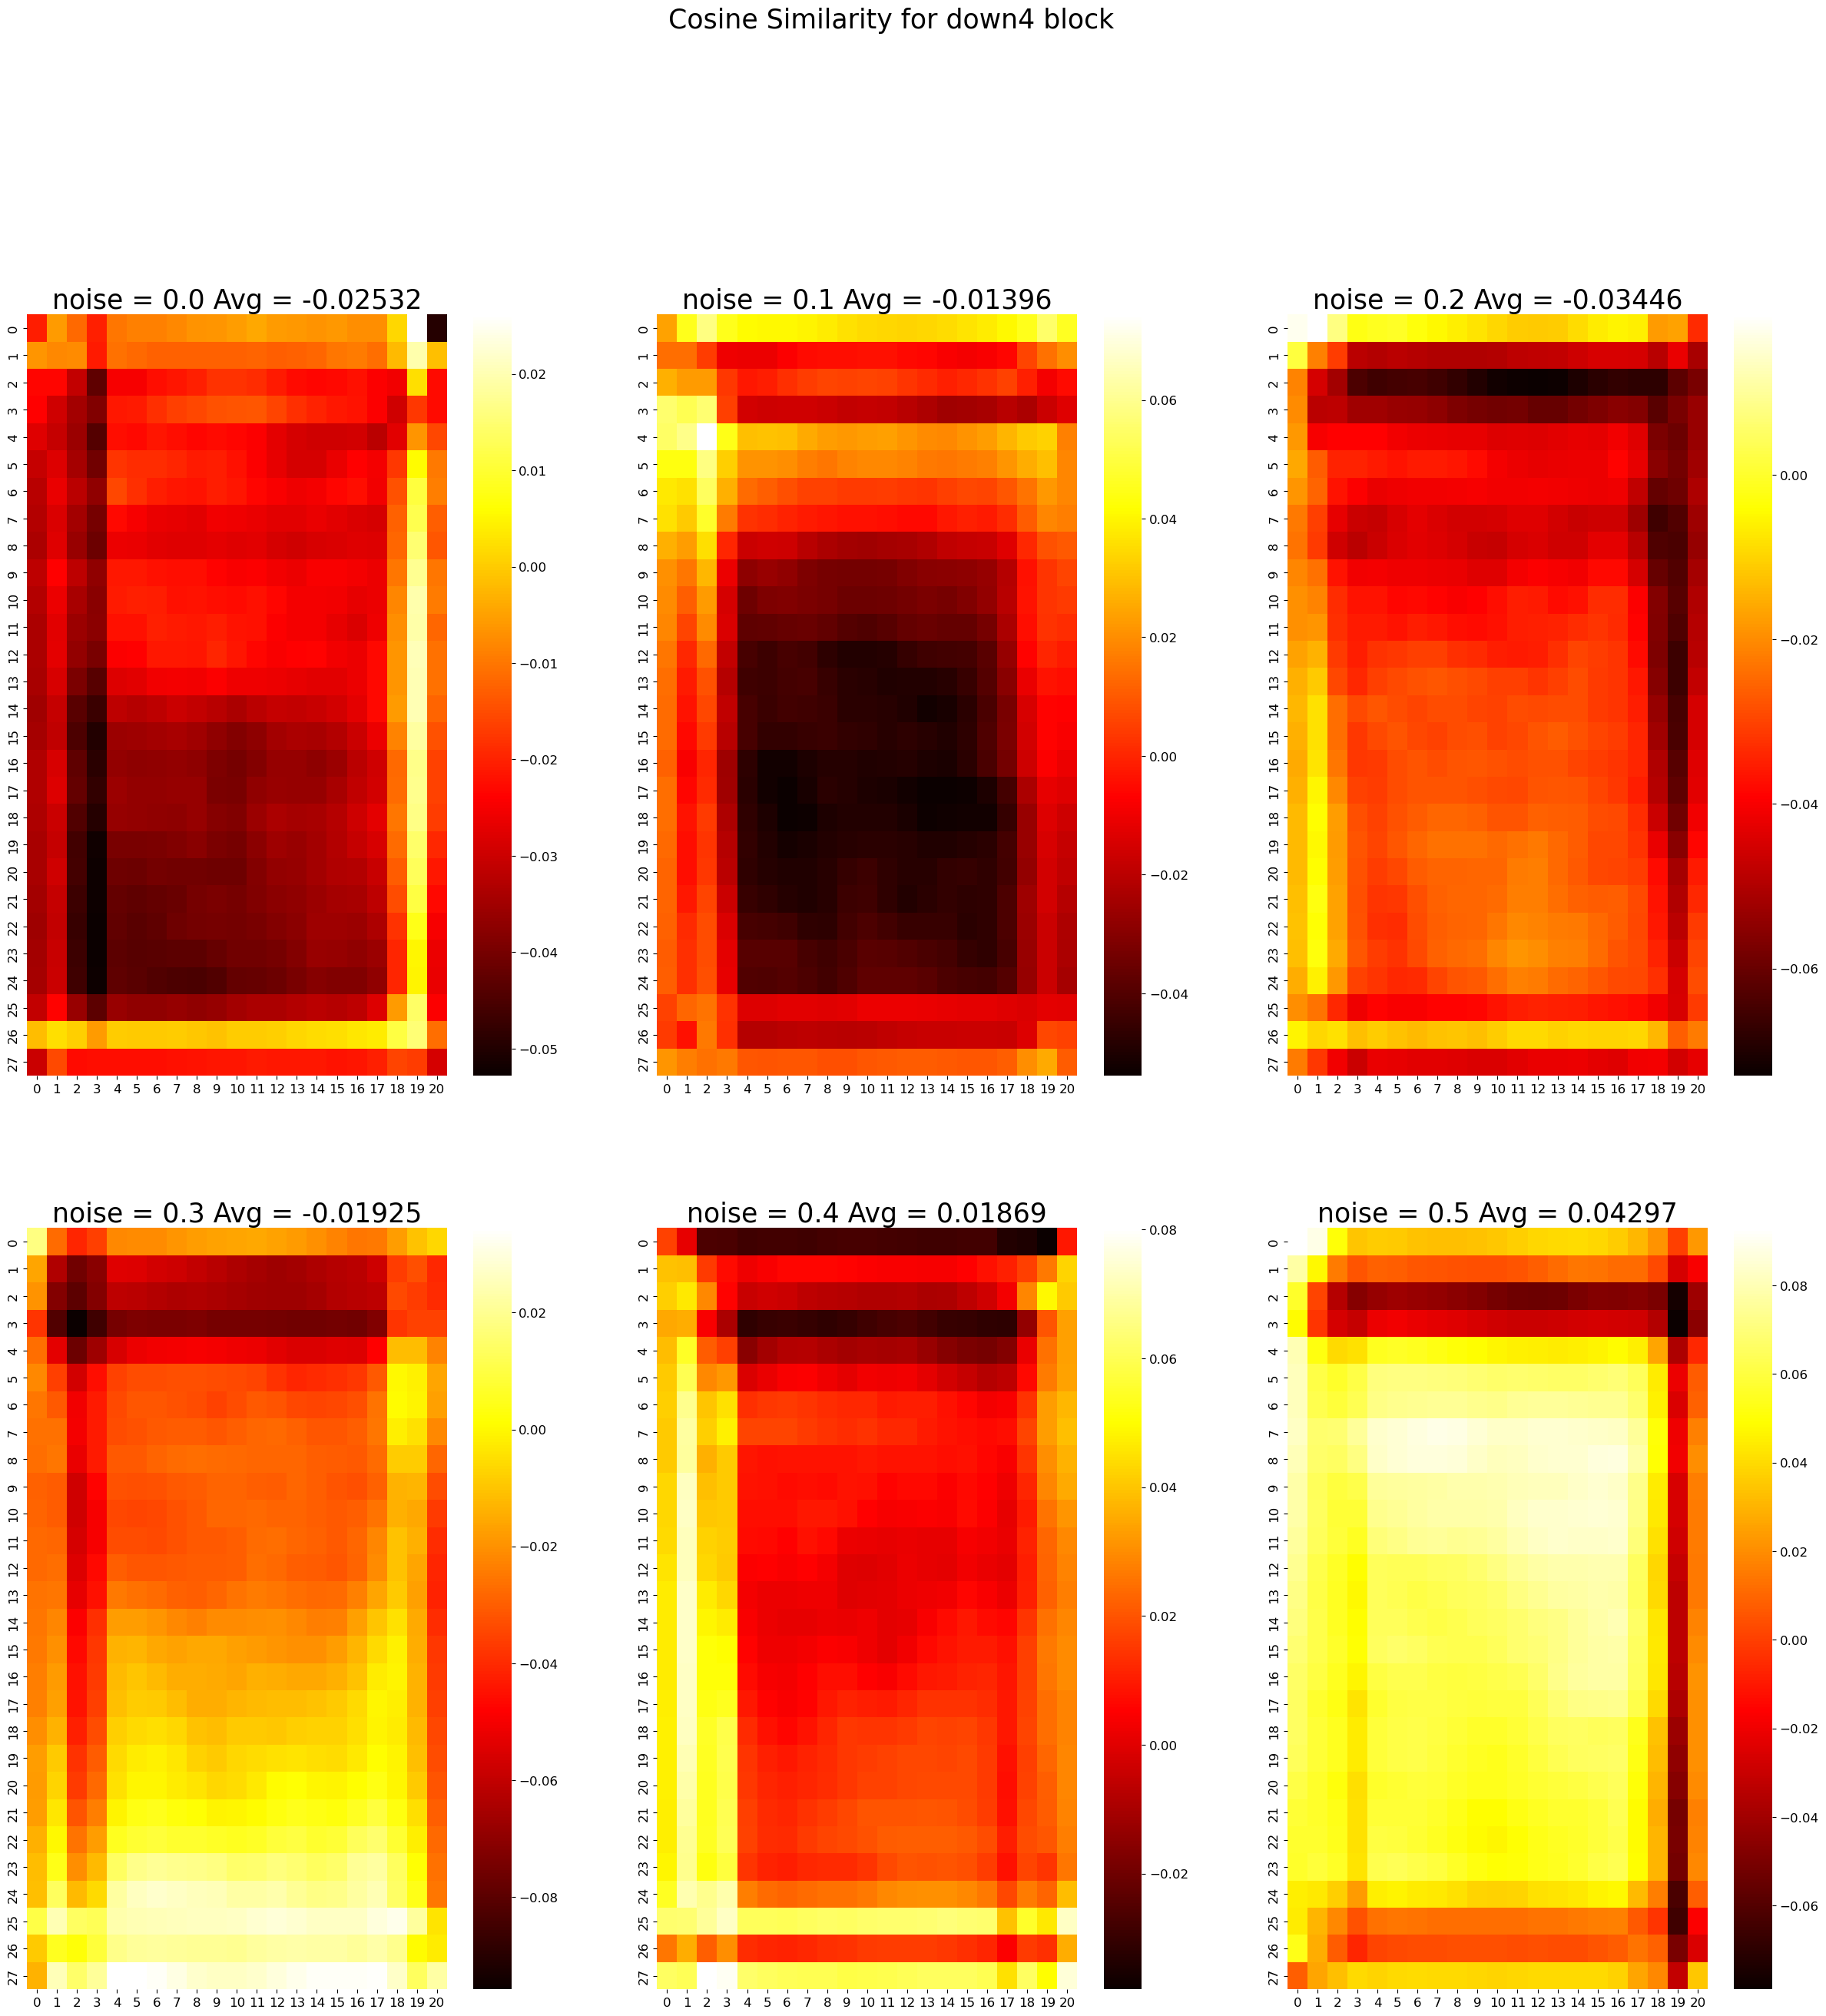

In [44]:
dirs = ['visualization/{}/down4'.format(str(i)) for i in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]]
plt.figure(figsize=(30, 20))
plt.suptitle('Cosine Similarity for down4 block', fontsize=25, y=1.4)
plt.subplots_adjust(top=1.2)
for idx, dir in enumerate(dirs): 
    plt.subplot(2, 3, idx+1)
    cos = cos_sims[idx]
    avg = cos_avgs[idx]
    plt.title('noise = {}'.format(str(dir.split('/')[-2] + ' Avg = ' + str(avg))), fontsize=25)
    sns.heatmap(cos.cpu().numpy(), cmap='hot')
plt.show()


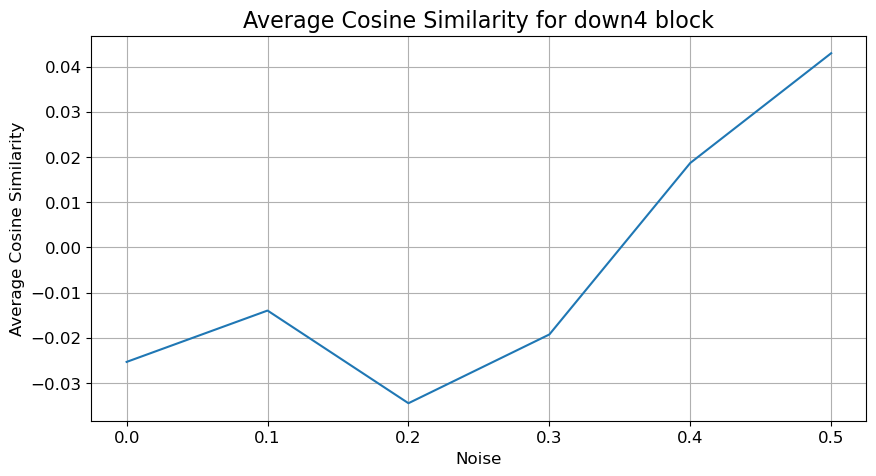

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(noise, cos_avgs)
plt.xlabel('Noise', fontsize=12)
plt.ylabel('Average Cosine Similarity', fontsize=12)
plt.title('Average Cosine Similarity for down4 block', fontsize=16)
plt.grid()
plt.show()